<a href="https://colab.research.google.com/github/agupta7654/ml-colab/blob/main/neural_machine_translation_student_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Encoder–Decoder Network for Neural Machine Translation

---



This notebook develops a traditional encoder-decoder translation model. It is a fork of the Auerlion Geron notebook found at https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb

But this version has been updated to comply with Keras 3, namely by implementing cusom loss and accuracy functions to accomodate masked output vectors.

Author: Patrick White

Students should read carefully all the code and run each cell. You will be given line-by-line instructions for implementing each layer of the network. Be sure to follow the instructions precisely and check your work often.

In [ ]:
from packaging import version
import tensorflow as tf
from tensorflow import keras

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [ ]:
## Download the spanish/english dataset

url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, extract=True) # cache_dir defaults to ~/.keras/datasets


from pathlib import Path
# The file might be extracted to a subdirectory within ~/.keras/datasets
# Search for 'spa.txt' in subdirectories:
dataset_path = Path(path).parent
for file_path in dataset_path.rglob('spa.txt'):
    if file_path.is_file():
        dataset_path = file_path
        break

text = dataset_path.read_text()

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

import numpy as np

# preprocess -- note how the lines are split up and shuffled and zipped together in pairs

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.shuffle(pairs)
sentences_english, sentences_spanish = zip(*pairs)  # separates the pairs into 2 lists

In [ ]:
for i in range(3):
    print(sentences_english[i], "=>", sentences_spanish[i])

I'm sorry for making you cry. => Lamento haberte hecho llorar.
She used to play tennis on Sunday. => Solía jugar al tenis los domingos.
I'll tell you the truth now. => Les diré la verdad ahora.


In [ ]:
vocab_size = 10000 # the size of our language vocab
max_length = 50 # max sentence length. shorter might train faster

# Now you will create layers to vectorize sentences into lists of arrays.
# Instead of preprocessing the sentences once, we create this as a layer in the model
# So the model input can be a text string.

# Do this: create a keras TextVectorization layer, layer_english_vectorization,  using the above parameters
# then call .adapt on that layer, passing in the english sentences as parameter

layer_english_vectorization = keras.layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length=max_length
)

layer_english_vectorization.adapt(sentences_english)

# now do the same with the spanish -- make and adapt a layer
# BUT for the spanish add 'starttoken' and 'endtoken' to each sentence first
sentences_spanish = [f'sssss {i} eeeee' for i in sentences_spanish]

layer_spanish_vectorization = keras.layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length=max_length
)

layer_spanish_vectorization.adapt(sentences_spanish)

In [ ]:
# this will show the top 10 tokens
layer_english_vectorization.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom'),
 np.str_('a'),
 np.str_('is'),
 np.str_('he')]

In [ ]:
# and the same for spanish
layer_spanish_vectorization.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('sssss'),
 np.str_('eeeee'),
 np.str_('de'),
 np.str_('que'),
 np.str_('a'),
 np.str_('no'),
 np.str_('tom'),
 np.str_('la')]

In [ ]:
# In this cell define
# X_train_encoder, X_valid_encoder, X_train_decoder_X_valid_decoder, Y_train and Y_valid

# X_train_encoder is the first 100,000 english sentences, conveted to tf.constant (input to the encoder layer)
# X_valid_encoder is the remainder

# X_train_decoder is the first 100,000 spanish sentences, with START token added only (input to the decoder layer)
# X_valid_decoder is similar

# the above are the INPUT sentences to the encoder and decoder

# Y_train are the corresponsing spanish sentences with END token added only. Pass it to the appropriate vectorization layer
# same with Y_valid
# Note Y_train is not one-hot-encoded BUT it is vectorized. Each Y-train entry is a vector of size 50 (or different if you changed the parameters)

X_train_encoder = tf.constant(sentences_english[:100000])
X_valid_encoder = tf.constant(sentences_english[100000:])

end_removed_spanish = [i[0:-6] for i in sentences_spanish]

X_train_decoder = tf.constant(end_removed_spanish[:100000])
X_valid_decoder = tf.constant(end_removed_spanish[100000:])

beginning_removed_spanish = [i[6:] for i in sentences_spanish]

Y_train = layer_spanish_vectorization(beginning_removed_spanish[:100000])
Y_valid = layer_spanish_vectorization(beginning_removed_spanish[100000:])

In [ ]:
# This should print 4 strings and 2 arrays. Check for appropriate tokens

print(X_train_encoder[0:1].numpy()[0].decode())
print(X_valid_encoder[0:1].numpy()[0].decode())
print(X_train_decoder[0:1].numpy()[0].decode())
print(X_valid_decoder[0:1].numpy()[0].decode())
print(Y_train[0:1].numpy())
print(Y_valid[0:1].numpy())

I'm sorry for making you cry.
How many Christmas presents did you give this year?
sssss Lamento haberte hecho llorar.
sssss Cuántos regalos navideños has repartido este año?
[[ 836 1084  165  689    3    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
[[ 492 1703 6335  129 9490   41  205    3    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [ ]:
# Create encoder_input_layer and decoder_input_layer
# These are keras input layers with shape = [], type = tf.string and appropriately named

encoder_input_layer = keras.layers.Input(
    shape = [],
    dtype = tf.string
)

decoder_input_layer = keras.layers.Input(
    shape = [],
    dtype = tf.string
)

In [ ]:
# Change this or leave it -- its the vector embedding dimension
embed_size = 512

# define encoder_vectors as the english vectorization layer applied to the encoder input layer
encoder_vectors = layer_english_vectorization(encoder_input_layer)

# define decoder vectors
decoder_vectors = layer_spanish_vectorization(decoder_input_layer)

# define an encoder_embedding_layer as a keras Embedding layer, with mask_zero = True
encoder_embedding_layer = keras.layers.Embedding(
    vocab_size,
    embed_size,
    mask_zero = True
)
# define an decoder_encoder_embedding_layer as a keras Embedding layer, with mask_zero = True
decoder_embedding_layer = keras.layers.Embedding(
    vocab_size,
    embed_size,
    mask_zero = True
)

# finally define encoder_embeddings and decoder_embeddings as the output of the embedding layers applied to the vectors
encoder_embeddings = encoder_embedding_layer(encoder_vectors)
decoder_embeddings = decoder_embedding_layer(decoder_vectors)

In [ ]:
# don't change but read carefully!!
encoder_lstm = tf.keras.layers.LSTM(512, return_state=True, dropout=0.2, name = "Encoder_LSTM")
encoder_outputs, *encoder_state = encoder_lstm(encoder_embeddings)

In [ ]:
# don't change but read carefully!!
decoder_lstm = tf.keras.layers.LSTM(512, return_sequences=True, dropout=0.2, name = "Decoder_LSTM")
decoder_outputs = decoder_lstm(decoder_embeddings, initial_state=encoder_state)

In [ ]:
# create a Dense output_layer of the appropriate size for the spanish vocabulary
output_layer = keras.layers.Dense(vocab_size, activation='softmax')
# output_layer = keras.layers.Dense(vocab_size)

# create a dropout_layer
dropout_layer = keras.layers.Dropout(0.2)

# define Y_proba. take the decoder_outputs through the dropout layer and into the dense layer
Y_proba = output_layer(dropout_layer(decoder_outputs))
# Y_proba = output_layer(decoder_outputs)

In [ ]:
# We need a custom loss function to deal with the zero padding

class MaskedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, name="masked_sparse_categorical_crossentropy"):
        super().__init__(reduction="none", name=name)
        self.from_logits = from_logits

    @tf.function  # Compiles into a TensorFlow graph for speed
    def call(self, y_true, y_pred):
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        mask = tf.cast(y_true != 0, dtype=tf.float32)  # Ignore padding (0 tokens)

        loss *= mask  # Apply mask
        loss_per_sequence = tf.reduce_sum(loss, axis=-1) / tf.maximum(tf.reduce_sum(mask, axis=-1), 1.0)

        return tf.reduce_mean(loss_per_sequence)  # Average over batch


In [ ]:
# We need a custom accuracy function to deal with the zero padding

class MaskedSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="masked_sparse_categorical_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct_predictions = self.add_weight(name="correct", initializer="zeros")
        self.total_valid = self.add_weight(name="total", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute predicted class (argmax for probabilities or logit inputs)
        y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int64)

        # Create mask where y_true != 0 (ignoring zero values)
        mask = tf.cast(y_true != 0, dtype=tf.float32)

        # Compare predictions with ground truth
        correct = tf.cast(tf.equal(y_true, y_pred_classes), dtype=tf.float32)

        # Apply mask
        correct *= mask

        # Update total count
        self.correct_predictions.assign_add(tf.reduce_sum(correct))
        self.total_valid.assign_add(tf.reduce_sum(mask))

    def result(self):
        return self.correct_predictions / tf.maximum(self.total_valid, 1.0)  # Avoid division by zero

    def reset_state(self):
        self.correct_predictions.assign(0)
        self.total_valid.assign(0)


In [ ]:
# A handy saving and stopping callback. Please update the save path!

class SaveBestModelWithEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, save_path="best_model.keras", patience=5):
        """
        Custom callback to:
        - Save the best model based on val_loss
        - Stop training if val_loss doesn't improve for 'patience' epochs

        Args:
            save_path (str): Path to save the best model.
            patience (int): Number of epochs to wait before stopping training if no improvement.
        """
        super().__init__()
        self.save_path = save_path
        self.patience = patience
        self.best_val_loss = float("inf")  # Initialize with a large value
        self.wait = 0  # Counter for patience

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get("val_loss")

        if val_loss is not None:
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.model.save(self.save_path)  # Save the entire model
                print(f"\nEpoch {epoch+1}: val_loss improved to {val_loss:.4f}. Model saved to {self.save_path}")
                self.wait = 0  # Reset patience counter
            else:
                self.wait += 1  # No improvement, increase patience counter
                print(f"\nEpoch {epoch+1}: val_loss did not improve. Patience: {self.wait}/{self.patience}")

            # Stop training if patience limit is reached
            if self.wait >= self.patience:
                print(f"\nEarly stopping triggered! No improvement for {self.patience} epochs.")
                self.model.stop_training = True

save_best_early_stop = SaveBestModelWithEarlyStopping(save_path="/content/drive/MyDrive/Junior Research Project/Seq2Seq Model/translator_A.keras", patience=2)

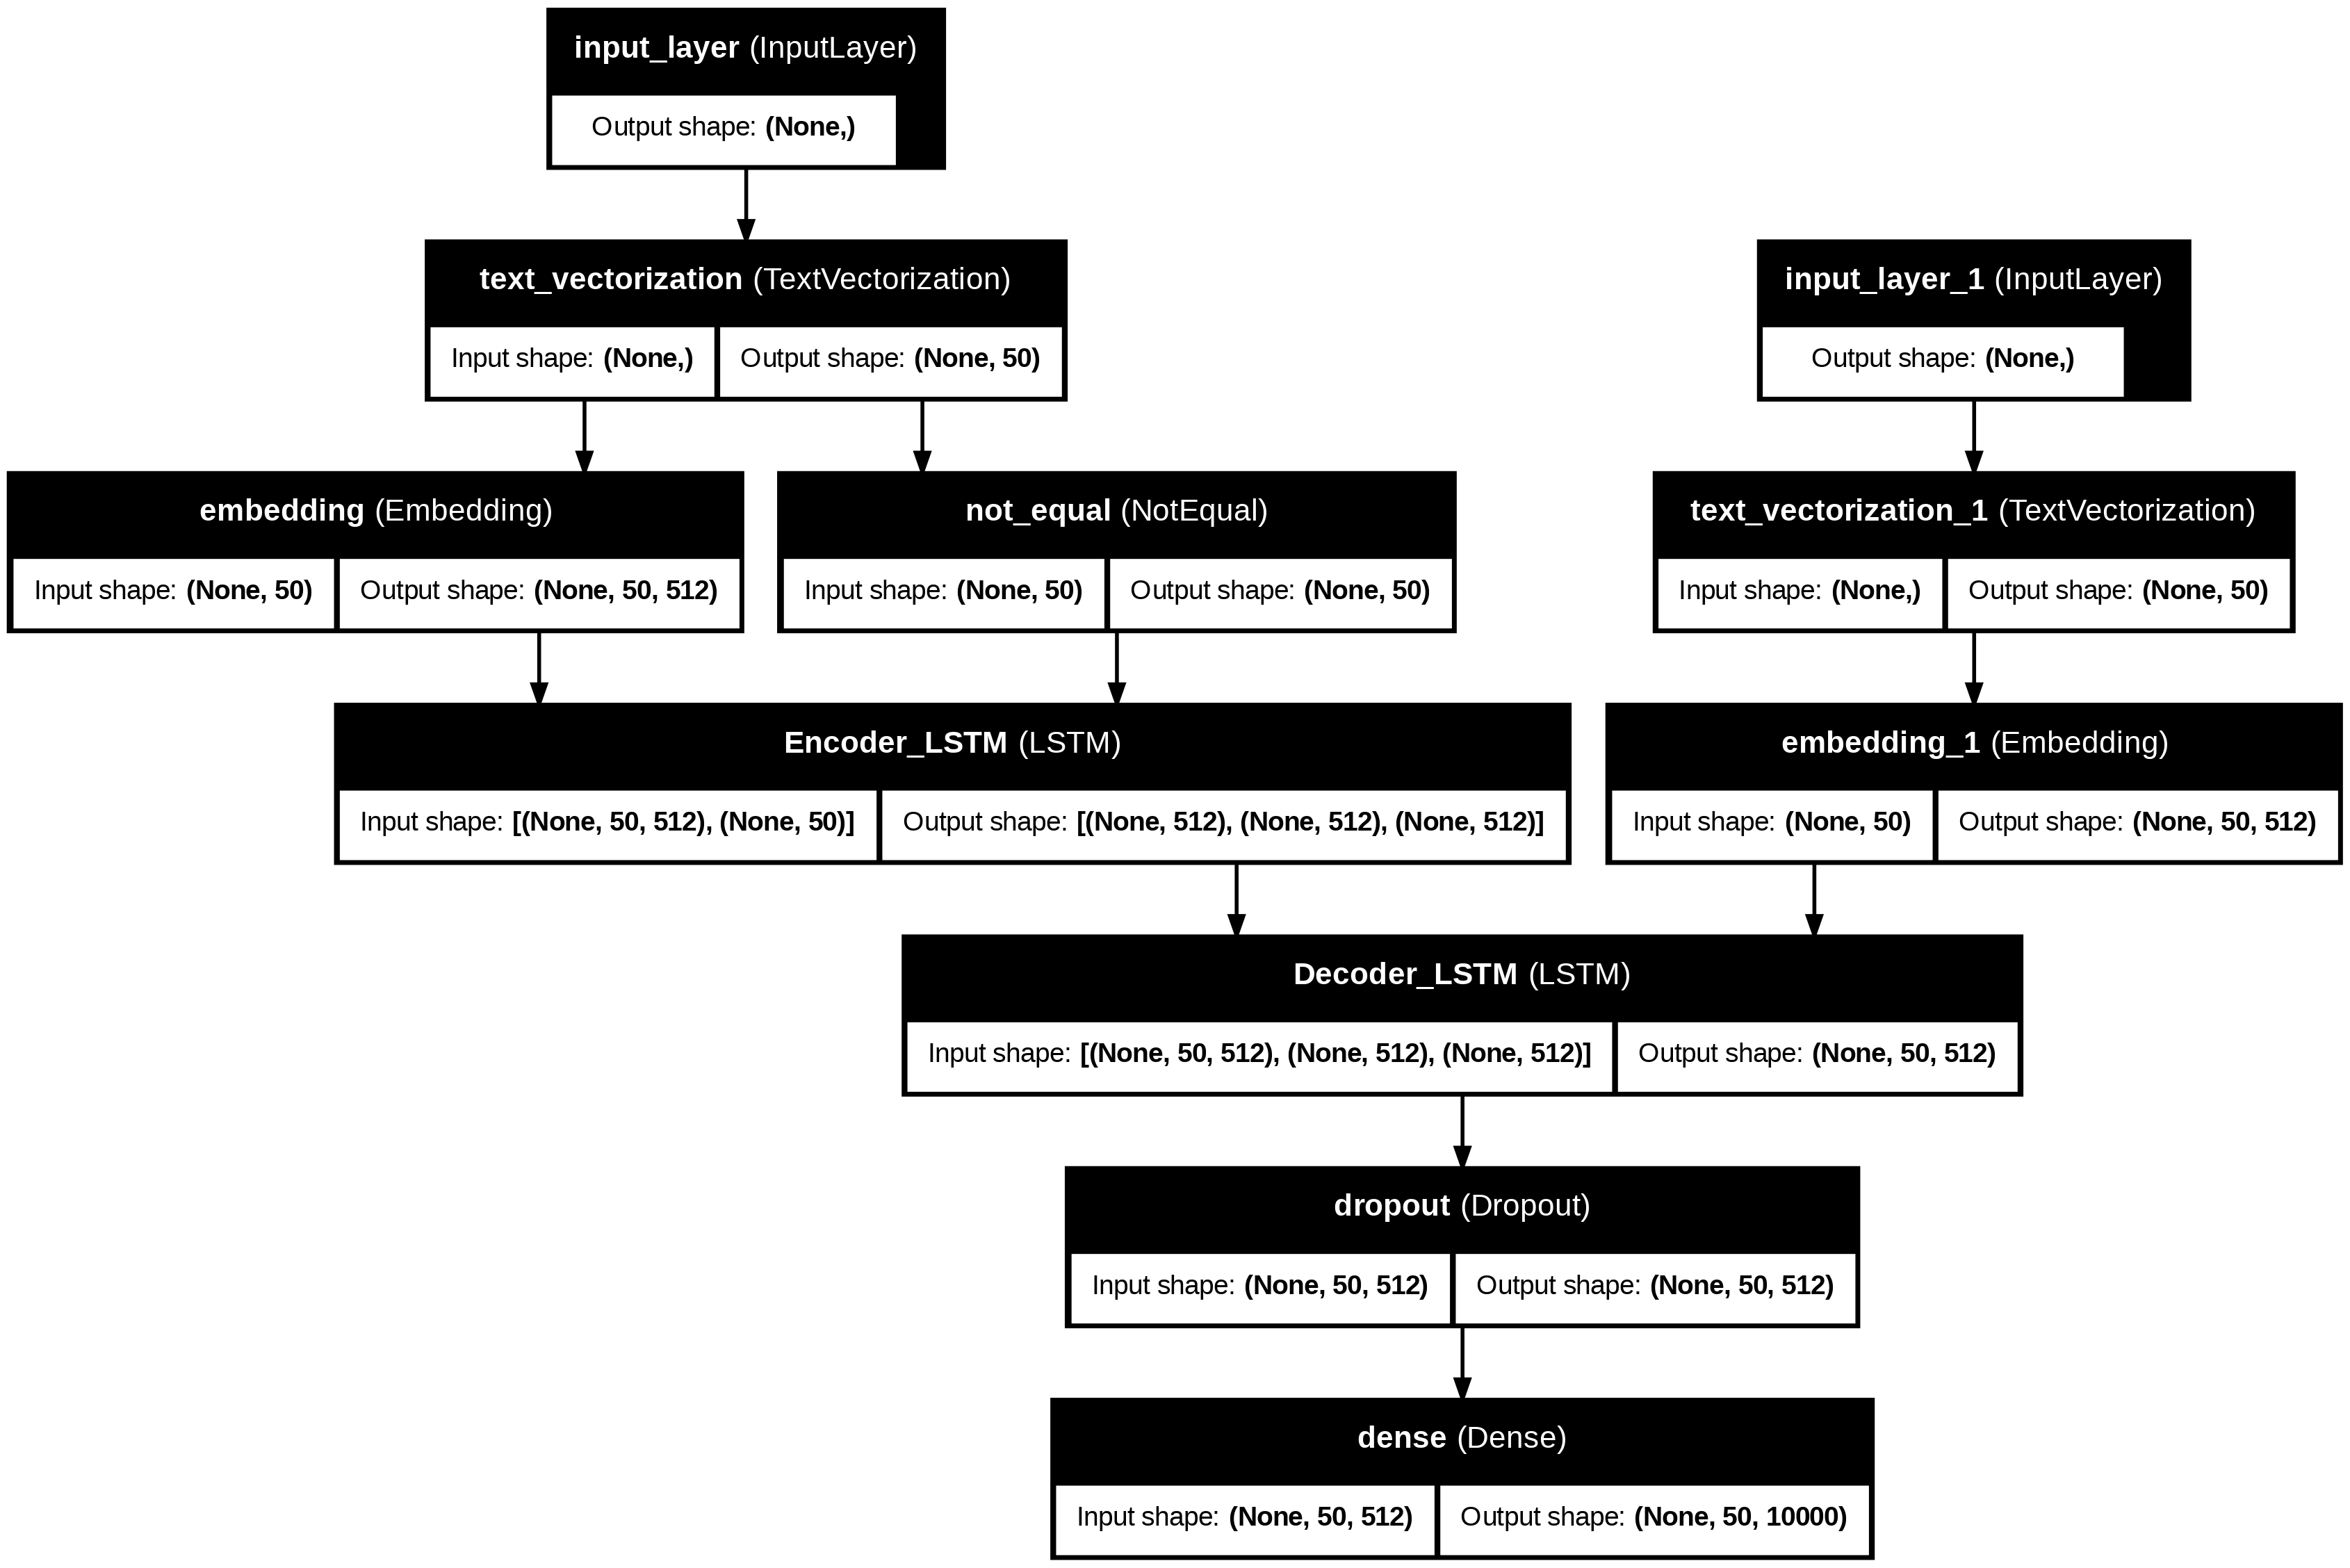

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Nadam

### BUILDING THE MODEL #####

### fill in the inputs as a list of the encoder and decoder inputs
#### fill in the outputs as a list containing the single output layer

model_A = tf.keras.Model(inputs= [encoder_input_layer, decoder_input_layer] ,
                       outputs=Y_proba)

# fill in the right loss and metrics and callbacks
model_A.compile(optimizer = 'nadam', loss = MaskedSparseCategoricalCrossentropy(from_logits=False), metrics = [MaskedSparseCategoricalAccuracy()])


# Plot the model architecture
plot_model(model_A, to_file='model_A_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# FIT the model. Accuracy will be in the 40-50 range probably. More epochs will increase it

model_A.fit((X_train_encoder, X_train_decoder), Y_train, epochs=3,
          validation_data=((X_valid_encoder, X_valid_decoder), Y_valid),
         callbacks = [save_best_early_stop])

Epoch 1/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.5443 - masked_sparse_categorical_accuracy: 0.3505
Epoch 1: val_loss improved to 0.4263. Model saved to /content/drive/MyDrive/Junior Research Project/Seq2Seq Model/translator_A.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 169s 431ms/step - loss: 0.5442 - masked_sparse_categorical_accuracy: 0.3506 - val_loss: 0.4263 - val_masked_sparse_categorical_accuracy: 0.4435
Epoch 2/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.3856 - masked_sparse_categorical_accuracy: 0.4651
Epoch 2: val_loss improved to 0.3430. Model saved to /content/drive/MyDrive/Junior Research Project/Seq2Seq Model/translator_A.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 180s 375ms/step - loss: 0.3856 - masked_sparse_categorical_accuracy: 0.4651 - val_loss: 0.3430 - val_masked_sparse_categorical_accuracy: 0.5200
Epoch 3/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.2956 - masked_sparse_categorical_accuracy: 0.5470
Epoch 3: val_loss improved to 0.2947. Model saved

In [ ]:
## a method to translate sentences

def translate(a_model, sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X =  tf.convert_to_tensor([sentence_en])  # encoder input
        X_dec = tf.convert_to_tensor(["sssss " + translation])
        y_proba = a_model.predict((X, X_dec), verbose=0)[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = layer_spanish_vectorization.get_vocabulary()[predicted_word_id]
        if predicted_word == "eeeee":
            break
        translation += " " + predicted_word
    return translation.strip()

In [ ]:
translate(model_A, "I like soccer")

'me gusta el fútbol'

Nice! However, the model struggles with longer sentences:

In [ ]:
translate(model_A, "I like soccer and also going to the beach")

'me gusta la primavera y la amo en el lugar'

In [ ]:
translate(model_A, "When I fell before the game I broke my leg")

'cuando me dejé el domingo siguiente puerta'

## Bidirectional RNNs

To create a bidirectional recurrent layer, just wrap a regular recurrent layer in a `Bidirectional` layer:

In [ ]:
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [ ]:
from tensorflow.keras.layers import Lambda

encoder_outputs, *encoder_state = encoder(encoder_embeddings)

# We have to split the outputs up into two because the Bidirectional layer has twice as many.
# Use a Lambda layer to handle the concatenation
def concatenate_states(states):
    short_term = tf.concat(states[::2], axis=-1)  # short-term (0 & 2)
    long_term = tf.concat(states[1::2], axis=-1)   # long-term (1 & 3)
    return [short_term, long_term]

# Apply the Lambda layer to the encoder state
encoder_state = Lambda(concatenate_states)(encoder_state)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [ ]:
# extra code — completes the model and trains it
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
save_best_early_stop = SaveBestModelWithEarlyStopping(save_path="/content/drive/MyDrive/Junior Research Project/Seq2Seq Model/translator_B.keras", patience=2)

model_B = tf.keras.Model(inputs=[encoder_input_layer, decoder_input_layer],
                       outputs=[Y_proba])
model_B.compile(loss=MaskedSparseCategoricalCrossentropy(from_logits=False), optimizer="nadam",
              metrics=[MaskedSparseCategoricalAccuracy()])
model_B.fit((X_train_encoder, X_train_decoder), Y_train, epochs=10, batch_size=256,
          validation_data=((X_valid_encoder, X_valid_decoder), Y_valid),
           callbacks = [save_best_early_stop])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.6656 - masked_sparse_categorical_accuracy: 0.3078
Epoch 1: val_loss improved to 0.3379. Model saved to /content/drive/MyDrive/Junior Research Project/Seq2Seq Model/translator_B.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 155s 384ms/step - loss: 0.6652 - masked_sparse_categorical_accuracy: 0.3081 - val_loss: 0.3379 - val_masked_sparse_categorical_accuracy: 0.5493
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 0.2675 - masked_sparse_categorical_accuracy: 0.6154
Epoch 2: val_loss improved to 0.2583. Model saved to /content/drive/MyDrive/Junior Research Project/Seq2Seq Model/translator_B.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 204s 389ms/step - loss: 0.2674 - masked_sparse_categorical_accuracy: 0.6155 - val_loss: 0.2583 - val_masked_sparse_categorical_accuracy: 0.6146
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 0.1785 - masked_sparse_categorical_accuracy: 0.7010
Epoch 3: val_loss improved to 0.2304. Model sa

In [ ]:
translate(model_B, "I like soccer")

'me gusta el fútbol'

In [ ]:
translate(model_B, "I like soccer and also going to the beach")

'me gusta la playa y el mar aún'

In [ ]:
translate(model_B, "When I fell on the football field I broke my leg")

'cuando me caí al suelo la primavera en el abuelo'

# Testing with TF-IDF

In [ ]:
## Download the spanish/english dataset

url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, extract=True) # cache_dir defaults to ~/.keras/datasets


from pathlib import Path
# The file might be extracted to a subdirectory within ~/.keras/datasets
# Search for 'spa.txt' in subdirectories:
dataset_path = Path(path).parent
for file_path in dataset_path.rglob('spa.txt'):
    if file_path.is_file():
        dataset_path = file_path
        break

text = dataset_path.read_text()

In [ ]:

import numpy as np

# preprocess -- note how the lines are split up and shuffled and zipped together in pairs

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.shuffle(pairs)
sentences_english, sentences_spanish = zip(*pairs)  # separates the pairs into 2 lists

In [ ]:
for i in range(3):
    print(sentences_english[i], "=>", sentences_spanish[i])

I want to be sure you understand what's going to happen. => Quiero estar seguro de que entiendes lo que va a pasar.
Is this too big? => Es esto demasiado grande?
It'll probably rain this afternoon. => Probablemente llueva esta tarde.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import tensorflow as tf

# Define parameters
vocab_size = 5000  # Max features for TF-IDF
max_length = 50     # Max sentence length (not directly needed in TF-IDF)

# Add start and end tokens to Spanish sentences
sentences_spanish = [f'sssss {i} eeeee' for i in sentences_spanish]

# Initialize and fit TF-IDF vectorizer for English
vectorizer_english = TfidfVectorizer(max_features=vocab_size)
vectorizer_english.fit(sentences_english)

# Initialize and fit TF-IDF vectorizer for Spanish
vectorizer_spanish = TfidfVectorizer(max_features=vocab_size)
vectorizer_spanish.fit(sentences_spanish)

TfidfVectorizer(max_features=5000)

In [ ]:
X_train_encoder = tf.constant(sentences_english[:100000])
X_valid_encoder = tf.constant(sentences_english[100000:])

end_removed_spanish = [i[0:-6] for i in sentences_spanish]

X_train_decoder = tf.constant(end_removed_spanish[:100000])
X_valid_decoder = tf.constant(end_removed_spanish[100000:])

beginning_removed_spanish = [i[6:] for i in sentences_spanish]

Y_train = vectorizer_spanish.transform(beginning_removed_spanish[:100000])
Y_valid = vectorizer_spanish.transform(beginning_removed_spanish[100000:])

In [ ]:
# This should print 4 strings and 2 arrays. Check for appropriate tokens

print(X_train_encoder[0:1].numpy()[0].decode())
print(X_valid_encoder[0:1].numpy()[0].decode())
print(X_train_decoder[0:1].numpy()[0].decode())
print(X_valid_decoder[0:1].numpy()[0].decode())
print(Y_train)
print(Y_valid)

I want to be sure you understand what's going to happen.
Tom told her that he had written that poem two years before.
sssss Quiero estar seguro de que entiendes lo que va a pasar.
sssss Tom le dijo que había escrito ese poema dos años antes.
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 638353 stored elements and shape (100000, 5000)>
  Coords	Values
  (0, 1230)	0.14883453856784523
  (0, 1562)	0.05445596792513444
  (0, 1705)	0.513437444094734
  (0, 1851)	0.3273905435992363
  (0, 2748)	0.2126354226118602
  (0, 3364)	0.39150662811058856
  (0, 3821)	0.3048304384130998
  (0, 3875)	0.27478376776747215
  (0, 4181)	0.36193232784925833
  (0, 4736)	0.3258316477754365
  (1, 1310)	0.5431360677056721
  (1, 1562)	0.08984283064137162
  (1, 1738)	0.2942002650126436
  (1, 1866)	0.4747962732468283
  (1, 2139)	0.6204403119696356
  (2, 1562)	0.06961678787685383
  (2, 1832)	0.3453866072302968
  (2, 2742)	0.6229947167888666
  (2, 3717)	0.5585456195672339
  (2, 4460)	0.41924452066433554
  (3

In [ ]:
encoder_input_layer = keras.layers.Input(
    shape = [],
    dtype = tf.string
)

decoder_input_layer = keras.layers.Input(
    shape = [],
    dtype = tf.string
)

In [ ]:
# Apply vectorization to convert raw text into numerical vectors before model input
encoder_vectors = vectorizer_english.transform(sentences_english)
decoder_vectors = vectorizer_spanish.transform(sentences_spanish)

# Now these are dense input tensors
encoder_input_layer = keras.Input(shape=(encoder_vectors.shape[1],))
decoder_input_layer = keras.Input(shape=(decoder_vectors.shape[1],))

In [ ]:
encoder_reduced = tf.keras.layers.Dense(512, activation='relu')(encoder_input_layer)

encoder_reshaped = tf.keras.layers.Reshape((1, 512))(encoder_reduced)

encoder_lstm = tf.keras.layers.LSTM(512, return_state=True, dropout=0.2, name="Encoder_LSTM")
encoder_outputs, *encoder_state = encoder_lstm(encoder_reshaped)

In [ ]:
decoder_reduced = tf.keras.layers.Dense(512, activation='relu')(decoder_input_layer)

# Expand dimensions: (batch_size, 1, features) so LSTM can process it
decoder_reshaped = tf.keras.layers.Reshape((1, 512))(decoder_reduced)

decoder_lstm = tf.keras.layers.LSTM(512, return_sequences=True, dropout=0.2, name="Decoder_LSTM")
decoder_outputs = decoder_lstm(decoder_reshaped, initial_state=encoder_state)

In [ ]:
# create a Dense output_layer of the appropriate size for the spanish vocabulary
output_layer = keras.layers.Dense(vocab_size, activation='softmax')
# output_layer = keras.layers.Dense(vocab_size)

# create a dropout_layer
dropout_layer = keras.layers.Dropout(0.2)

# define Y_proba. take the decoder_outputs through the dropout layer and into the dense layer
Y_proba = output_layer(dropout_layer(decoder_outputs))
# Y_proba = output_layer(decoder_outputs)

In [ ]:
# We need a custom loss function to deal with the zero padding

class MaskedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, name="masked_sparse_categorical_crossentropy"):
        super().__init__(reduction="none", name=name)
        self.from_logits = from_logits

    @tf.function  # Compiles into a TensorFlow graph for speed
    def call(self, y_true, y_pred):
        # if len(y_pred.shape) == 3:
        #     y_pred_squeezed = tf.squeeze(y_pred, axis=1)  # Remove extra dimension if present
        # else:
        #     y_pred_squeezed = y_pred
        if isinstance(y_true, tf.sparse.SparseTensor):
            y_true = tf.sparse.to_dense(y_true, default_value=0)

        y_pred = tf.reshape(y_pred, (-1, 5000, 1))

        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        mask = tf.cast(y_true != 0, dtype=tf.float32)  # Ignore padding (0 tokens)

        loss *= mask  # Apply mask
        loss_per_sequence = tf.reduce_sum(loss, axis=-1) / tf.maximum(tf.reduce_sum(mask, axis=-1), 1.0)

        return tf.reduce_mean(loss_per_sequence)  # Average over batch


In [ ]:
# We need a custom accuracy function to deal with the zero padding

class MaskedSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="masked_sparse_categorical_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct_predictions = self.add_weight(name="correct", initializer="zeros")
        self.total_valid = self.add_weight(name="total", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute predicted class (argmax for probabilities or logit inputs)
        # y_pred_squeezed = tf.squeeze(y_pred, axis=1)
        y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int64)

        # Create mask where y_true != 0 (ignoring zero values)
        mask = tf.cast(y_true != 0, dtype=tf.float32)

        # Compare predictions with ground truth
        correct = tf.cast(tf.equal(y_true, y_pred_classes), dtype=tf.float32)

        # Apply mask
        correct *= mask

        # Update total count
        self.correct_predictions.assign_add(tf.reduce_sum(correct))
        self.total_valid.assign_add(tf.reduce_sum(mask))

    def result(self):
        return self.correct_predictions / tf.maximum(self.total_valid, 1.0)  # Avoid division by zero

    def reset_state(self):
        self.correct_predictions.assign(0)
        self.total_valid.assign(0)


In [ ]:
# A handy saving and stopping callback. Please update the save path!

class SaveBestModelWithEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, save_path="best_model.keras", patience=5):
        """
        Custom callback to:
        - Save the best model based on val_loss
        - Stop training if val_loss doesn't improve for 'patience' epochs

        Args:
            save_path (str): Path to save the best model.
            patience (int): Number of epochs to wait before stopping training if no improvement.
        """
        super().__init__()
        self.save_path = save_path
        self.patience = patience
        self.best_val_loss = float("inf")  # Initialize with a large value
        self.wait = 0  # Counter for patience

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get("val_loss")

        if val_loss is not None:
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.model.save(self.save_path)  # Save the entire model
                print(f"\nEpoch {epoch+1}: val_loss improved to {val_loss:.4f}. Model saved to {self.save_path}")
                self.wait = 0  # Reset patience counter
            else:
                self.wait += 1  # No improvement, increase patience counter
                print(f"\nEpoch {epoch+1}: val_loss did not improve. Patience: {self.wait}/{self.patience}")

            # Stop training if patience limit is reached
            if self.wait >= self.patience:
                print(f"\nEarly stopping triggered! No improvement for {self.patience} epochs.")
                self.model.stop_training = True

save_best_early_stop = SaveBestModelWithEarlyStopping(save_path="/content/drive/MyDrive/Junior Research Project/Seq2Seq Model/translator_C.keras", patience=2)

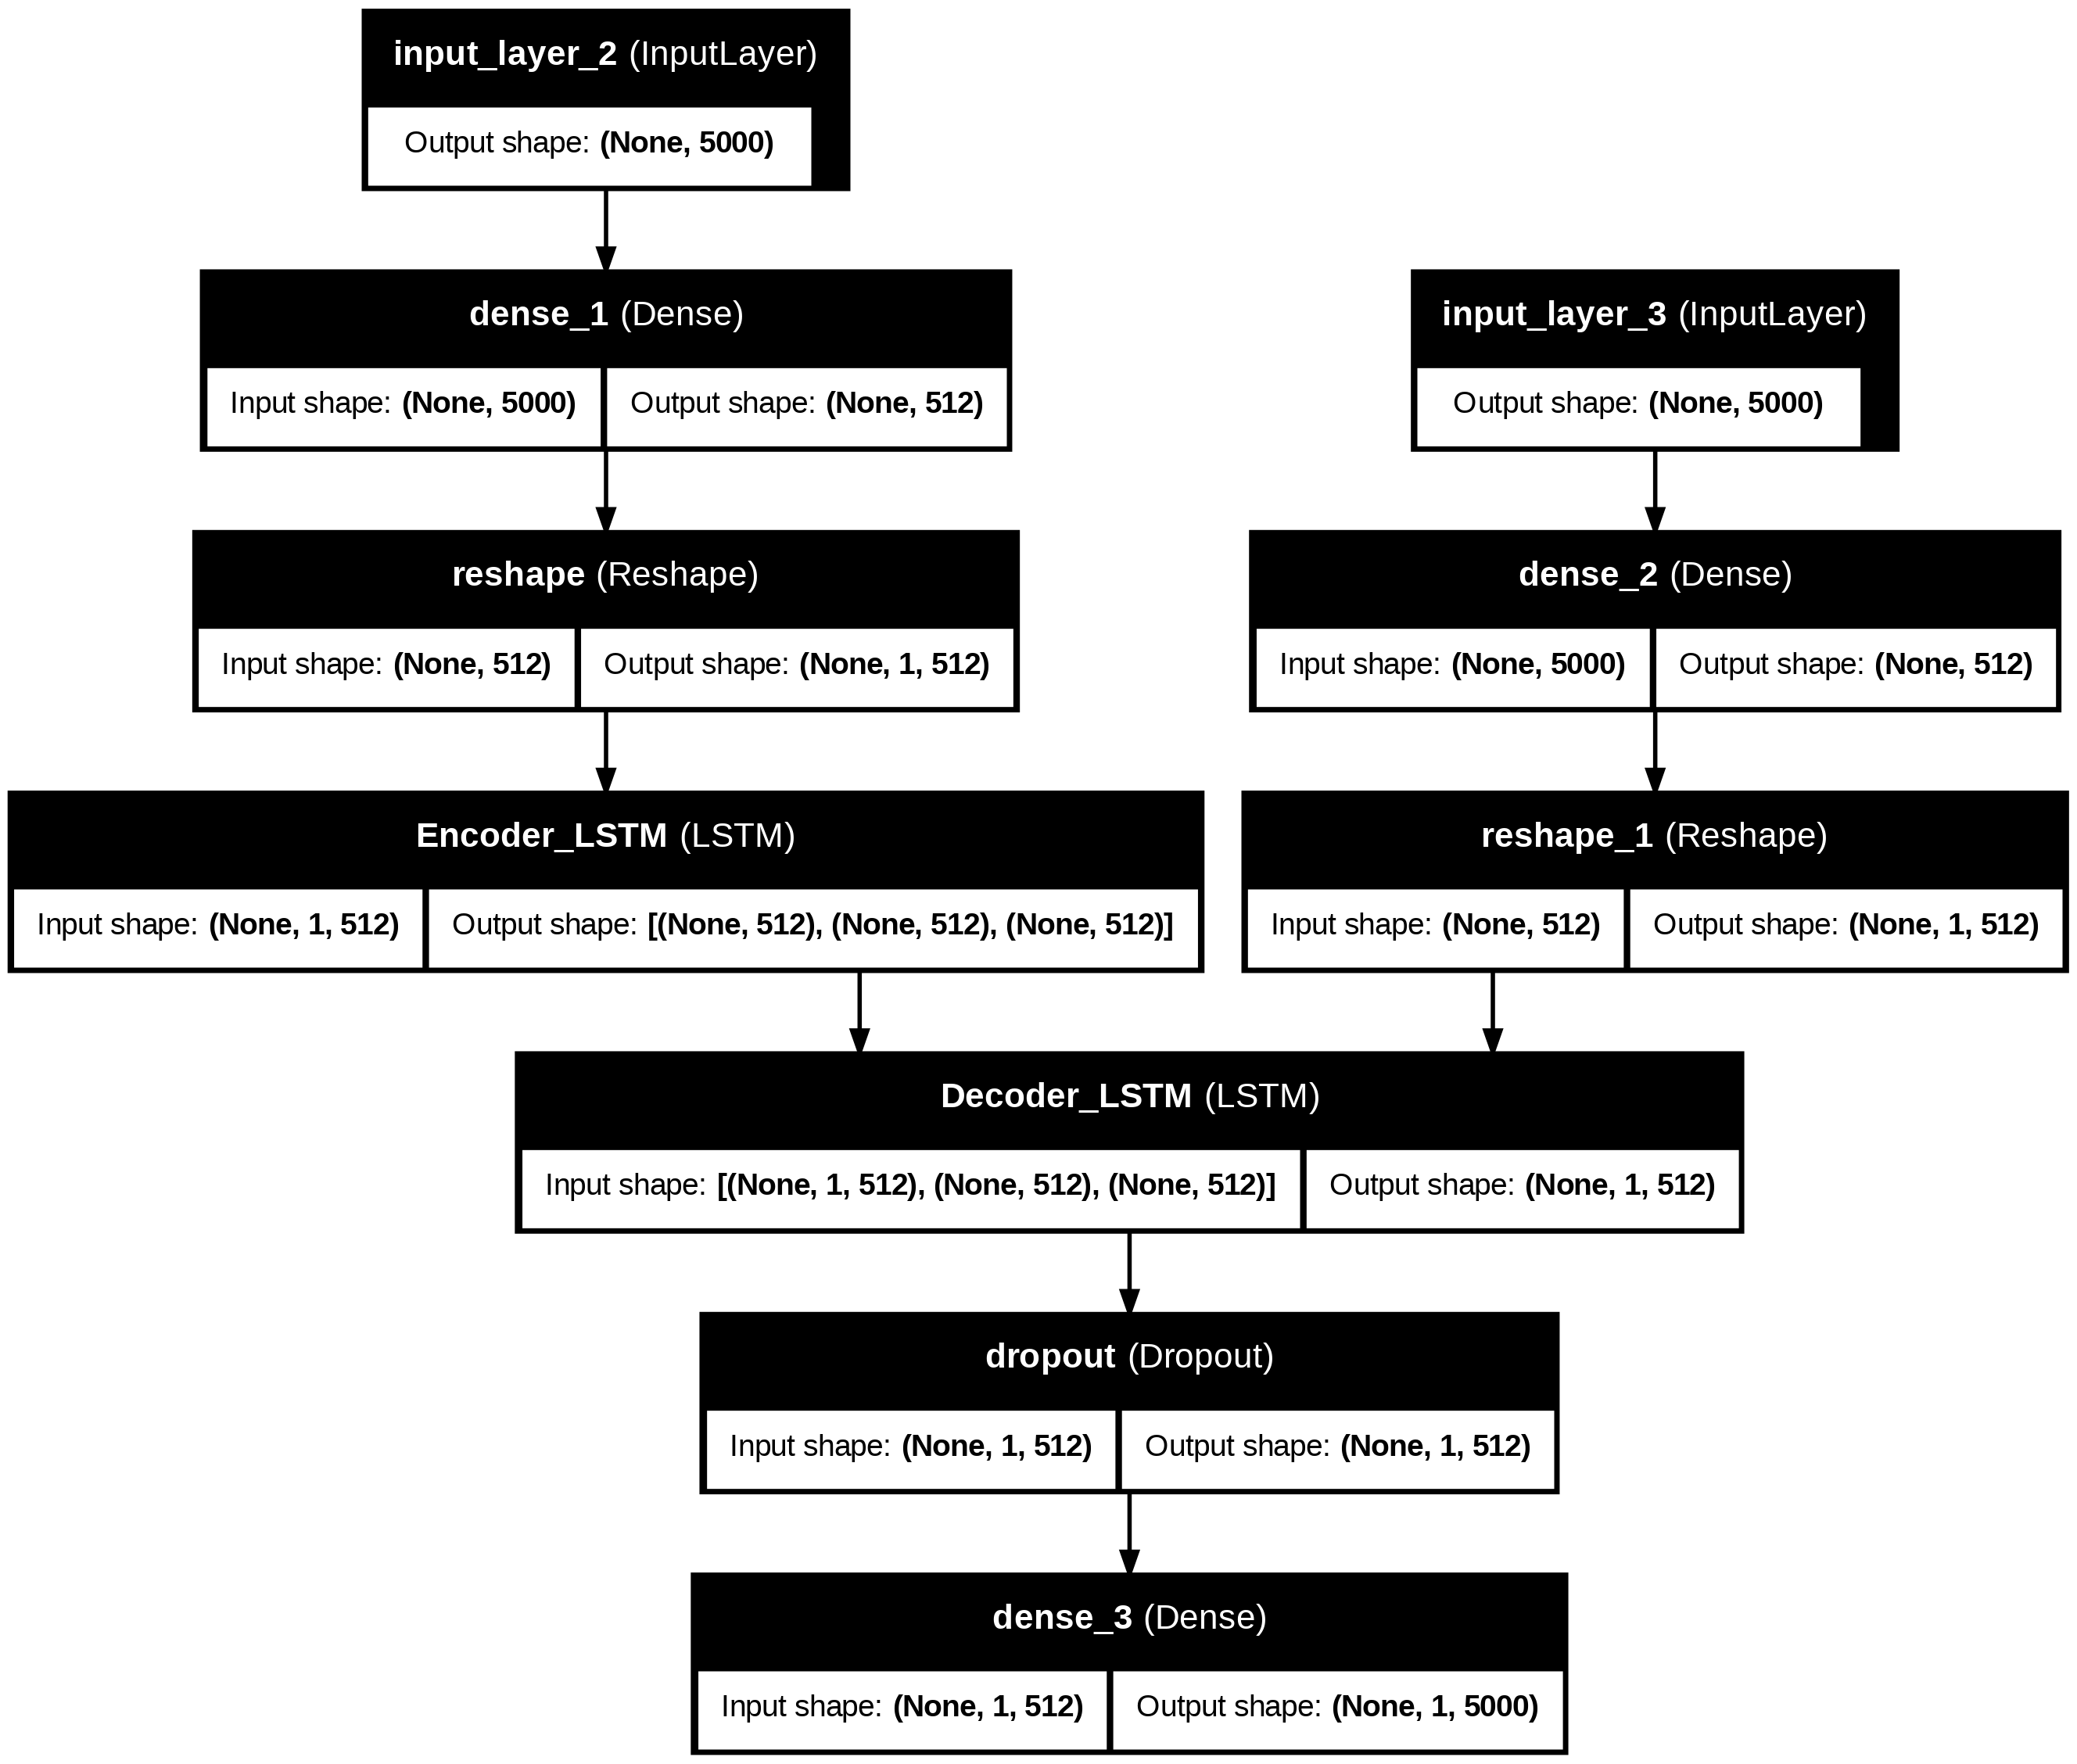

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Nadam

### BUILDING THE MODEL #####

### fill in the inputs as a list of the encoder and decoder inputs
#### fill in the outputs as a list containing the single output layer

model_C = tf.keras.Model(inputs= [encoder_input_layer, decoder_input_layer] ,
                       outputs=Y_proba)

# fill in the right loss and metrics and callbacks
model_C.compile(optimizer = 'nadam', loss = MaskedSparseCategoricalCrossentropy(from_logits=False), metrics = [MaskedSparseCategoricalAccuracy()])


# Plot the model architecture
plot_model(model_C, to_file='model_C_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Ensure proper decoding to UTF-8
X_train_encoder_text = [str(text.numpy(), 'utf-8') for text in X_train_encoder]
X_train_decoder_text = [str(text.numpy(), 'utf-8') for text in X_train_decoder]

X_valid_encoder_text = [str(text.numpy(), 'utf-8') for text in X_valid_encoder]
X_valid_decoder_text = [str(text.numpy(), 'utf-8') for text in X_valid_decoder]

In [ ]:
Y_train = tf.cast(Y_train.toarray(), tf.int64)

In [ ]:
# Now apply the vectorizer
X_train_encoder_tfidf = vectorizer_english.transform(X_train_encoder_text)
X_train_decoder_tfidf = vectorizer_spanish.transform(X_train_decoder_text)

X_valid_encoder_tfidf = vectorizer_english.transform(X_valid_encoder_text)
X_valid_decoder_tfidf = vectorizer_spanish.transform(X_valid_decoder_text)

In [ ]:
# model_C.fit((X_train_encoder_tfidf, X_train_decoder_tfidf), Y_train, epochs=3, batch_size = 128,
#           validation_data=((X_valid_encoder_tfidf, X_valid_decoder_tfidf), Y_valid),
#          callbacks = [save_best_early_stop])

Epoch 1/3
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: nan - masked_sparse_categorical_accuracy: 0.0000e+00

TypeError: Failed to convert elements of SparseTensor(indices=Tensor("data_6:0", shape=(None, 2), dtype=int64), values=Tensor("data_7:0", shape=(None,), dtype=float32), dense_shape=Tensor("data_8:0", shape=(2,), dtype=int64)) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.